In [ ]:
from helpers import (
    preprocessing
)
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, DateType, FloatType, ArrayType, LongType, MapType, DateType
import warnings
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
warnings.filterwarnings('ignore')

In [ ]:
# instancia spark
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.memory","4G") \
    .config("spark.driver.memory","4G") \
    .config("spark.executor.cores","12") \
    .config("spark.sql.execution.arrow.pyspark.enabled","true") \
    .getOrCreate()

## Preprocessing Data

In [ ]:
# base de dados do twitter ja classificada com sentimentos
path = "/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/raw_kaggle/TweetsWithTheme_v2.csv"

In [ ]:
# dataframe twitter com sentimentos classificados
dataframe = spark.read.options(delimiter=';',header='True').csv(path)

In [ ]:
# label adjust
dataframe = dataframe.withColumn("sentiment_map", 
    F.when(F.col("sentiment")=="Negativo", 0).otherwise(1)
)

In [ ]:
# dataframe features
rdd2 = dataframe.rdd.map(lambda x: (preprocessing(x.tweet_text),len(preprocessing(x.tweet_text).split()),x.sentiment_map))

schema = StructType([       
    StructField('features', StringType(), True),
    StructField('tokens_count', IntegerType(), True),
    StructField('label', IntegerType(), True),
])

df_features = spark.createDataFrame(rdd2, schema = schema)

count_map = F.udf( 
    lambda x: len(x.split()),
    IntegerType()     
)

df_features = df_features \
    .filter(F.col("features")!="-") \
    .filter( count_map(F.col("features"))<30 ) \
    .dropDuplicates(subset = ['features'])

In [ ]:
train = df_features.sampleBy("label", fractions={0: 1, 1: 0.87}, seed=10)

In [ ]:
# features and labels
features = train.select('features').rdd.flatMap(lambda x: x).collect()
labels = np.array(train.select('label').rdd.flatMap(lambda x: x).collect())

In [ ]:
## MODEL TESTS  LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def tf_idf_features(tokens, num_features):

    try:
        vectorizer = CountVectorizer(max_features=num_features)
        vectorizer.fit(tokens)
        X_vectorizer = vectorizer.transform(tokens)

        tf_idf_transformer = TfidfTransformer()
        tf_idf_transformer.fit(X_vectorizer)
        X_train_tf_idf = tf_idf_transformer.transform(X_vectorizer)

        return csr_matrix(np.array([np.pad(x, (0, num_features-len(x)), 'constant', constant_values=0) for x in X_train_tf_idf.toarray()]))
    
    except:
        return csr_matrix([np.pad(np.array([0]), (0, 1999), 'constant', constant_values=0)])

In [ ]:
## MODEL TESTS  MultinomialNB

def train_and_show_scores(x_features: csr_matrix, num_features: int,y: np.array) -> None:
    
    X_train_tf_idf = tf_idf_features(x_features, num_features)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_tf_idf, y, train_size=0.7, random_state=42
    )

    clf = MultinomialNB()

    alpha = [100, 10, 1.0, 0.1, 0.01]
    grid = dict(alpha=alpha)
    
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)

    random_search_cv = RandomizedSearchCV(
        estimator=clf,
        param_distributions=grid,
        n_jobs=-1, 
        cv=kfold,
        n_iter=20
    )

    random_search_cv.fit(X_train, y_train)
    y_pred_train = random_search_cv.predict(X_train)
    y_pred_valid = random_search_cv.predict(X_valid)

    print(classification_report_imbalanced(y_train, y_pred_train))
    print(classification_report_imbalanced(y_valid, y_pred_valid))

    return random_search_cv

y_train = labels

In [ ]:
model_nb = train_and_show_scores(features,2000,y_train)

## Model prediction with new data

In [ ]:
model_nb.predict_proba(tf_idf_features(['Lula é um péssimo presidente do Brasil','Bolsonaro é ruim'],2000))

In [ ]:
model_nb.predict(tf_idf_features(['Lula é um péssimo presidente do Brasil','Bolsonaro é ruim'],2000))

## Model prediction with new tweets data

In [ ]:
path_tweets = "/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/trusted/tweets_preprocessing"

In [ ]:
df_tweets = spark.read.parquet(path_tweets).toPandas()

In [ ]:
df_tweets['tf_idf'] = df_tweets['text_clean'].apply(lambda x: tf_idf_features([x],2000))

In [ ]:
df_tweets['sentiment'] = [model_nb.predict(mtx)[0] for mtx in df_tweets['tf_idf']]

In [ ]:
df_tweets['sentiment'].value_counts()

In [ ]:
df_tweets.to_pickle('/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/refined/tweets_naive_bayes/tweets_naive_bayes.pkl')

## ANALISE SERIE TEMPORAL

In [5]:
import pandas as pd
import numpy as np

df_tweets = pd.read_pickle('/home/daholive/Documents/twitter_ellection_brazil_v2/datasource/refined/tweets_naive_bayes/tweets_naive_bayes.pkl')

In [6]:
df_tweets_resume = df_tweets[['query','created_at_tz','sentiment']]

In [7]:
df_tweets_analysis = df_tweets_resume.groupby(['query','created_at_tz','sentiment']).agg(
    {
        'sentiment':'count'
    }
).rename(columns={'sentiment':'count'}).reset_index().pivot_table(
    values='count',
    index=['query','created_at_tz'],
    columns=['sentiment'],
    aggfunc=np.sum
).rename(columns={0:'Negative',1:'Positive'}).reset_index()

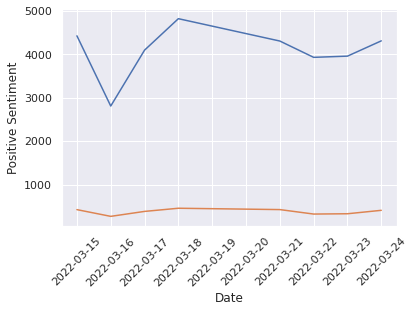

In [8]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

df_lula = df_tweets_analysis[
    (df_tweets_analysis['query']=='lula') & ((df_tweets_analysis['created_at_tz']>datetime(2022,3,14).date()) & (df_tweets_analysis['created_at_tz']<datetime(2022,3,25).date()))
][['created_at_tz','Negative','Positive']]

sns.set()   

plt.ylabel('Positive Sentiment')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.plot(df_lula.created_at_tz, df_lula['Positive'])
plt.plot(df_lula.created_at_tz, df_lula['Negative'])